# Team ASYC notebook

*First we installed the necessary libraries:*

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

import matplotlib.pyplot as plt # matplotlib and seaborn for plotting
import matplotlib.patches as patches
import seaborn as sns

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import os,random, math, psutil, pickle

from time import time
import datetime
pd.set_option('display.max_columns',100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

root = '../input/ashrae-energy-prediction'
print(os.listdir(root))

Then we upload the dataframes. 
We parse the datetime data and use specific dtypes for the building and weather dataframe. 
Also for the test dataframe we select to read especific columns.

In [ ]:
train = pd.read_csv(root + "/train.csv", parse_dates=['timestamp'])

weather_train = pd.read_csv(root+"/weather_train.csv",parse_dates=['timestamp'])

test_cols_to_read = ['building_id','meter','timestamp']
test = pd.read_csv(root+"/test.csv",parse_dates=['timestamp'],usecols=test_cols_to_read)

weather_test = pd.read_csv(root + "/weather_test.csv", parse_dates=['timestamp'])

building_meta = pd.read_csv(root + "/building_metadata.csv")

sample_submission = pd.read_csv(root + "/sample_submission.csv")

Now we take a look of the size of the tables:

In [ ]:
print('Size of train data', train.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building_meta data', building_meta.shape)

# Timestamps Adjustments

In [ ]:
weather = pd.concat([weather_train,weather_test],ignore_index=True)
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

In [ ]:
data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour
count = 1
plt.figure(figsize=(25, 15))
for site_id, data_by_site in data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del data_to_plot

* We calculate ranks of hourly temperatures within date/site_id chunks.
* Then create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23).
* And we subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
* Finally we do a function to align the timestamps.

In [ ]:
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

We reduce the memory size. 
Function to reduce the DF size:

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
building_site_dict = dict(zip(building_meta['building_id'], building_meta['site_id']))
site_meter_raw = train[['building_id', 'meter', 'timestamp', 'meter_reading']].copy()
site_meter_raw['site_id'] = site_meter_raw.building_id.map(building_site_dict)
del site_meter_raw['building_id']
site_meter_to_plot = site_meter_raw.copy()
site_meter_to_plot["hour"] = site_meter_to_plot["timestamp"].dt.hour
elec_to_plot = site_meter_to_plot[site_meter_to_plot.meter == 0]

In [ ]:
count = 1
plt.figure(figsize=(25, 50))
for site_id, data_by_site in elec_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(15, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['meter_reading'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del elec_to_plot, site_meter_to_plot, building_site_dict, site_meter_raw

**Reducing memory:**

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
building_meta = reduce_mem_usage(building_meta)

In [ ]:
weather_train = timestamp_align(weather_train)
weather_test = timestamp_align(weather_test)
del weather

We review the dataframes:

In [ ]:
print('train info',train.info())
print('-------------------')
print('weather_train info', weather_train.info())
print('-------------------')
print('test info', test.info()) 
print('-------------------')
print('weather_test info', weather_test.info())
print('-------------------')
print('building info', building_meta.info())

# Exploratory Data Analysis
## Looking for missing values

We see the basic statistical measures of the dataframes:

In [ ]:
train.head()

In [ ]:
train.describe(include='all')

* Data contains records from 1st Jan to 31st Dec of 2016.
* Data has information about 1448 buildings.
* Data has 4 meter types.
* Some extremely high values in meter reading which can be explored further.

In [ ]:
test.head()

In [ ]:
test.describe(include='all')

* Time period in **test data** is 2017 and 2018
* We see that the test data points are a bit more than the double of the train data points...

We check for missing values on the test and train dataframes:

In [ ]:
missing_train_test = pd.DataFrame(train.isna().sum()/len(train),columns=["Missing_Pct_Train"])
missing_train_test["Missing_Pct_Test"] = test.isna().sum()/len(test)
missing_train_test

No Missing values in train/test datasets

In [ ]:
building_meta.head()

In [ ]:
building_meta.describe(include='all')

*For the building metadata we see:*
* There are only 16 different primary uses and Education is the most frecuent with 549 apperances. 
* For the square feet the maximum is 875000 and the minimum is 283.
* For the year built there is a range between 1900 till 2017. 
* For the floor count the average and median coincide in 3 floors; we see that the maximum floor count is 26.
* And that there are some missing values for the year_built and floor_count columns.

We divide the number of missing values by the overall number of values to see which columns have missing values:

In [ ]:
building_meta.isna().sum()/len(building_meta)*100

In [ ]:
weather_train.head()

In [ ]:
weather_train.describe()

In [ ]:
weather_test.head()

In [ ]:
weather_test.describe()

* We see that almost all columns have missing values on the weather's datasets.
* For the columns cloud_coverage and precip_depth_1_hr we see a lot of values = 0.

We divide the number of missing values by the overall number of values to compare the number of missing values in Weather_Train and Weather_Test:

In [ ]:
missing_weather = pd.DataFrame(weather_train.isna().sum()/len(weather_train)*100,columns=["Weather_Train_Missing_Pct"]) 
missing_weather["Weather_Test_Missing_Pct"] = weather_test.isna().sum()/len(weather_test)*100 
missing_weather

* **precip_depth_1_hr variable** and **cloud_coverage variable** have similar number of missing values in both train and test weather data.
* site_id and timestamp do not have missing values.
* Other variables have some missing values.

### Calculating Min_value and Max_value of the columns in Weather_train:

In [ ]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    print (" Minimum Value of {} column is {}".format(col,weather_train[col].min()))
    print (" Maximum Value of {} column is {}".format(col,weather_train[col].max()))
    print ("----------------------------------------------------------------------")

In [ ]:
weather_train['timestamp'].describe()

> This data is from 31st Dec 2015 to 31st Dec 2016, similar to the timestamp of the training data

In [ ]:
#creating a distplot of columns air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.distplot(weather_train[col].dropna())

* Cloud_Coverage takes distinct values unlike these other variables.
* Dew Temperature looks like a Negatively skewed distribution.
* Lot of 0 values in precip_depth_1_hr variable.
* Distribution of sea_level_pressure looks like a normal distribution.
* Wind_Speed distribution looks like positively skewed.

In [ ]:
weather_test['timestamp'].describe()

> The time duration is similar to the test dataset.

# Dealing with missing values 

**Before we start filling missing values, we drop floor_count column as it has more than 75% missing values.** 
> It will manipulate the training data into a different direction if we impute it.<br /> 
> Also,year_built also has a large number of missing columns, but we leave it for now.

In [ ]:
building_meta.drop('floor_count',axis=1,inplace=True)
building_meta.head()

### We fill out the missing values in the weather columns both in train and test

As we read so many popular tutorials and suggestion, there are few main solutions to fill in the missing values.
1. Just ignore the data row 
2. Back-fill or forward-fill to propagate next or previous values respectively
3. Replace with some constant value outside fixed value range-999,-1 etc.
4. Replace with mean or median value. 

> Most of tutorials implement the way 'the daily mean of each site per month'. It had been proven the most logical and proven method so far.<br /> 
> We will fill with the mean of the filler object created by grouping site_id, day and month if daily means per month / site_id is not available.
--Ref2 and Ref3 <br />

First, we do for the **building part**:

In [ ]:
# since NA values only present in building age fillna can be used
building_meta.fillna(round(building_meta.year_built.mean(),0),
                inplace=True)

In [ ]:
building_meta.head()
building_meta.isna().sum()

We had quite a deal of missing values in the training and testing dataset, except site_id and time_stamp. 

First We deal with wheather_train

In [ ]:
# add month, day of week, day of month and hour 
weather_train['month'] = weather_train['timestamp'].dt.month.astype(np.int8)
weather_train['day_of_week'] = weather_train['timestamp'].dt.dayofweek.astype(np.int8)
weather_train['day_of_month']= weather_train['timestamp'].dt.day.astype(np.int8)
weather_train['hour'] = weather_train['timestamp'].dt.hour

# add is weekend column
weather_train['is_weekend'] = weather_train.day_of_week.apply(lambda x: 1 if x>=5 else 0)

In [ ]:
def convert_season(month):
    if (month <= 2) | (month == 12):
        return 0
    # as winter
    elif month <= 5:
        return 1
    # as spring
    elif month <= 8:
        return 2
    # as summer
    elif month <= 11:
        return 3
    # as fall

In [ ]:
weather_train['season'] = weather_train.month.apply(convert_season)

In [ ]:
#Reset Index for Update for training 
weather_train = weather_train.set_index(
    ['site_id','day_of_month','month'])

**Air temperature**

In [ ]:
# create dataframe of daily means per site id 
air_temperature_filler = pd.DataFrame(weather_train
                                      .groupby(['site_id','day_of_month','month'])
                                      ['air_temperature'].mean(),
                                      columns=["air_temperature"])
air_temperature_filler.isna().sum()

In [ ]:
# create dataframe of air_temperatures to fill
temporary_df = pd.DataFrame({'air_temperature' : weather_train.air_temperature})

# update NA air_temperature values
temporary_df.update(air_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_train["air_temperature"] = temporary_df["air_temperature"]

del temporary_df, air_temperature_filler
gc.collect()

**Cloud Coverage**

In [ ]:
# create dataframe of daily means per site id
cloud_coverage_filler = pd.DataFrame(weather_train
                                     .groupby(['site_id','day_of_month','month'])
                                     ['cloud_coverage'].mean(),
                                     columns = ['cloud_coverage'])
cloud_coverage_filler.isna().sum()

Because cloud_coverage takes discrete values and still have some NA value, I will fill it again with rounded mean

In [ ]:
round(cloud_coverage_filler.cloud_coverage.mean(),0)
cloud_coverage_filler.fillna(round(cloud_coverage_filler.cloud_coverage.mean(),0), 
                             inplace=True)

# create dataframe of cloud_coverages to fill
temporary_df = pd.DataFrame({'cloud_coverage' : weather_train.cloud_coverage})

# update NA cloud_coverage values
temporary_df.update(cloud_coverage_filler, overwrite=False)

# update in the weather train dataset
weather_train["cloud_coverage"] = temporary_df["cloud_coverage"]

del temporary_df, cloud_coverage_filler
gc.collect()

**Dew Temperature**

In [ ]:
# create dataframe of daily means per site id
dew_temperature_filler = pd.DataFrame(weather_train
                                      .groupby(['site_id','day_of_month','month'])
                                      ['dew_temperature'].mean(),
                                      columns=["dew_temperature"])
dew_temperature_filler.isna().sum()

In [ ]:
# create dataframe of dew_temperatures to fill
temporary_df = pd.DataFrame({'dew_temperature' : weather_train.dew_temperature})

# update NA dew_temperature values
temporary_df.update(dew_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_train["dew_temperature"] = temporary_df["dew_temperature"]

del temporary_df, dew_temperature_filler
gc.collect()

**Precip Depth 1 Hour**

In [ ]:
# create dataframe of daily means per site id
precip_depth_filler = pd.DataFrame(weather_train
                                   .groupby(['site_id','day_of_month','month'])
                                   ['precip_depth_1_hr'].mean(),
                                   columns=['precip_depth_1_hr'])
precip_depth_filler.isna().sum()

As cloud_coverage, I fill NA values of the filler with the rounded mean since the discrete values and still got some NA

In [ ]:
round(precip_depth_filler['precip_depth_1_hr'].mean(),0)
precip_depth_filler.fillna(round(precip_depth_filler['precip_depth_1_hr'].mean(),0)
                           , inplace=True)

# create dataframe of precip_depth_1_hr to fill
temporary_df = pd.DataFrame({'precip_depth_1_hr' : weather_train.precip_depth_1_hr})

# update NA precip_depth_1_hr values
temporary_df.update(precip_depth_filler, overwrite=False)

# update in the weather train dataset
weather_train["precip_depth_1_hr"] = temporary_df["precip_depth_1_hr"]

del precip_depth_filler, temporary_df
gc.collect()

**Sea Level Pressure**

In [ ]:
# create dataframe of daily means per site id
sea_level_filler = pd.DataFrame(weather_train
                                .groupby(['site_id','day_of_month','month'])
                                ['sea_level_pressure'].mean(),
                                columns=['sea_level_pressure'])
sea_level_filler.isna().sum()

We did the same as with cloud_coverage:

In [ ]:
mean_sea_level_pressure = round(
    sea_level_filler
    ['sea_level_pressure']
    .astype(float)
    .mean(),2)

In [ ]:
sea_level_filler.fillna(mean_sea_level_pressure, inplace=True)

# create dataframe of sea_level_pressure to fill
temporary_df = pd.DataFrame({'sea_level_pressure' : weather_train.sea_level_pressure})

# update NA sea_level_pressure values
temporary_df.update(sea_level_filler, overwrite=False)

# update in the weather train dataset
weather_train["sea_level_pressure"] = temporary_df["sea_level_pressure"]

del sea_level_filler, temporary_df
gc.collect()

**Wind Direction**

In [ ]:
# create dataframe of daily means per site id
wind_direction_filler = pd.DataFrame(weather_train
                                     .groupby(['site_id','day_of_month','month'])
                                     ['wind_direction'].mean(),
                                     columns=['wind_direction'])
wind_direction_filler.isna().sum()

In [ ]:
# create dataframe of wind_direction to fill
temporary_df = pd.DataFrame({'wind_direction' : weather_train.wind_direction})

# update NA wind_direction values
temporary_df.update(wind_direction_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_direction"] = temporary_df["wind_direction"]

del temporary_df, wind_direction_filler
gc.collect()

**Wind Speed**

In [ ]:
# create dataframe of daily means per site id
wind_speed_filler = pd.DataFrame(weather_train
                                 .groupby(['site_id','day_of_month','month'])
                                 ['wind_speed'].mean(),
                                 columns=['wind_speed'])
wind_speed_filler.isna().sum()

In [ ]:
# create dataframe of wind_speed to fill
temporary_df = pd.DataFrame({'wind_speed' : weather_train.wind_speed})

# update NA wind_speed values
temporary_df.update(wind_speed_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_speed"] = temporary_df["wind_speed"]

del temporary_df, wind_speed_filler
gc.collect()

In [ ]:
# check if NA values left
weather_train.isna().sum()

We reset indexes to transfrom weather dataframe to original form:

In [ ]:
weather_train = weather_train.reset_index()

In [ ]:
weather_train.drop('day_of_month',axis=1,inplace=True)
weather_train.drop('month',axis=1,inplace=True)
weather_train.drop('day_of_week',axis=1,inplace=True)
weather_train.drop('hour',axis=1,inplace=True)
weather_train.drop('is_weekend',axis=1,inplace=True)
weather_train.drop('season',axis=1,inplace=True)

In [ ]:
weather_train.sample(5)

 Repeat again for wheather_test

In [ ]:
# add month, day of week, day of month and hour 
weather_test['month'] = weather_test['timestamp'].dt.month.astype(np.int8)
weather_test['day_of_week'] = weather_test['timestamp'].dt.dayofweek.astype(np.int8)
weather_test['day_of_month']= weather_test['timestamp'].dt.day.astype(np.int8)
weather_test['hour'] = weather_test['timestamp'].dt.hour

# add is weekend column
weather_test['is_weekend'] = weather_test.day_of_week.apply(lambda x: 1 if x>=5 else 0)

weather_test['season'] = weather_test.month.apply(convert_season)

#Reset Index for Update for training 
weather_test = weather_test.set_index(
    ['site_id','day_of_month','month'])

#Air temperature


# create dataframe of daily means per site id 
air_temperature_filler = pd.DataFrame(weather_test
                                      .groupby(['site_id','day_of_month','month'])
                                      ['air_temperature'].mean(),
                                      columns=["air_temperature"])
air_temperature_filler.isna().sum()

# create dataframe of air_temperatures to fill
temporary_df = pd.DataFrame({'air_temperature' : weather_test.air_temperature})

# update NA air_temperature values
temporary_df.update(air_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_test["air_temperature"] = temporary_df["air_temperature"]

del temporary_df, air_temperature_filler
gc.collect()

#Cloud Coverage

# create dataframe of daily means per site id
cloud_coverage_filler = pd.DataFrame(weather_test
                                     .groupby(['site_id','day_of_month','month'])
                                     ['cloud_coverage'].mean(),
                                     columns = ['cloud_coverage'])
cloud_coverage_filler.isna().sum()

#Because cloud_coverage takes discrete values and still have some NA value, I will fill it again with rounded mean

round(cloud_coverage_filler.cloud_coverage.mean(),0)
cloud_coverage_filler.fillna(round(cloud_coverage_filler.cloud_coverage.mean(),0), 
                             inplace=True)

# create dataframe of cloud_coverages to fill
temporary_df = pd.DataFrame({'cloud_coverage' : weather_test.cloud_coverage})

# update NA cloud_coverage values
temporary_df.update(cloud_coverage_filler, overwrite=False)

# update in the weather train dataset
weather_test["cloud_coverage"] = temporary_df["cloud_coverage"]

del temporary_df, cloud_coverage_filler
gc.collect()

#Dew Temperature

# create dataframe of daily means per site id
dew_temperature_filler = pd.DataFrame(weather_test
                                      .groupby(['site_id','day_of_month','month'])
                                      ['dew_temperature'].mean(),
                                      columns=["dew_temperature"])
dew_temperature_filler.isna().sum()

# create dataframe of dew_temperatures to fill
temporary_df = pd.DataFrame({'dew_temperature' : weather_test.dew_temperature})

# update NA dew_temperature values
temporary_df.update(dew_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_test["dew_temperature"] = temporary_df["dew_temperature"]

del temporary_df, dew_temperature_filler
gc.collect()

#Precip Depth 1 Hour

# create dataframe of daily means per site id
precip_depth_filler = pd.DataFrame(weather_test
                                   .groupby(['site_id','day_of_month','month'])
                                   ['precip_depth_1_hr'].mean(),
                                   columns=['precip_depth_1_hr'])
precip_depth_filler.isna().sum()

#As cloud_coverage, I fill NA values of the filler with the rounded mean since the discrete values and still got some NA


round(precip_depth_filler['precip_depth_1_hr'].mean(),0)
precip_depth_filler.fillna(round(precip_depth_filler['precip_depth_1_hr'].mean(),0)
                           , inplace=True)

# create dataframe of precip_depth_1_hr to fill
temporary_df = pd.DataFrame({'precip_depth_1_hr' : weather_test.precip_depth_1_hr})

# update NA precip_depth_1_hr values
temporary_df.update(precip_depth_filler, overwrite=False)

# update in the weather train dataset
weather_test["precip_depth_1_hr"] = temporary_df["precip_depth_1_hr"]

del precip_depth_filler, temporary_df
gc.collect()

#Sea Level Pressure

# create dataframe of daily means per site id
sea_level_filler = pd.DataFrame(weather_test
                                .groupby(['site_id','day_of_month','month'])
                                ['sea_level_pressure'].mean(),
                                columns=['sea_level_pressure'])
sea_level_filler.isna().sum()

#We did the same as with cloud_coverage:

mean_sea_level_pressure = round(
    sea_level_filler
    ['sea_level_pressure']
    .astype(float)
    .mean(),2)

sea_level_filler.fillna(mean_sea_level_pressure, inplace=True)

# create dataframe of sea_level_pressure to fill
temporary_df = pd.DataFrame({'sea_level_pressure' : weather_test.sea_level_pressure})

# update NA sea_level_pressure values
temporary_df.update(sea_level_filler, overwrite=False)

# update in the weather train dataset
weather_test["sea_level_pressure"] = temporary_df["sea_level_pressure"]

del sea_level_filler, temporary_df
gc.collect()

#Wind Direction

# create dataframe of daily means per site id
wind_direction_filler = pd.DataFrame(weather_test
                                     .groupby(['site_id','day_of_month','month'])
                                     ['wind_direction'].mean(),
                                     columns=['wind_direction'])
wind_direction_filler.isna().sum()

# create dataframe of wind_direction to fill
temporary_df = pd.DataFrame({'wind_direction' : weather_test.wind_direction})

# update NA wind_direction values
temporary_df.update(wind_direction_filler, overwrite=False)

# update in the weather train dataset
weather_test["wind_direction"] = temporary_df["wind_direction"]

del temporary_df, wind_direction_filler
gc.collect()

#Wind Speed


# create dataframe of daily means per site id
wind_speed_filler = pd.DataFrame(weather_test
                                 .groupby(['site_id','day_of_month','month'])
                                 ['wind_speed'].mean(),
                                 columns=['wind_speed'])
wind_speed_filler.isna().sum()

# create dataframe of wind_speed to fill
temporary_df = pd.DataFrame({'wind_speed' : weather_test.wind_speed})

# update NA wind_speed values
temporary_df.update(wind_speed_filler, overwrite=False)

# update in the weather train dataset
weather_test["wind_speed"] = temporary_df["wind_speed"]

del temporary_df, wind_speed_filler
gc.collect()

# check if NA values left
weather_test.isna().sum()

#We reset indexes to transfrom weather dataframe to original form:

weather_test = weather_test.reset_index()

weather_test.drop('day_of_month',axis=1,inplace=True)
weather_test.drop('month',axis=1,inplace=True)
weather_test.drop('day_of_week',axis=1,inplace=True)
weather_test.drop('hour',axis=1,inplace=True)
weather_test.drop('is_weekend',axis=1,inplace=True)
weather_test.drop('season',axis=1,inplace=True)

weather_test.sample(5)

## We merge train data (train, building, weather) into 1 dataframe:

In [ ]:
train_total = pd.merge(train,building_meta,how='left',on='building_id')
train_total = pd.merge(train_total,weather_train,how='left',on=["site_id", "timestamp"])
train_total.info()

In [ ]:
train_total.sample(5)

## We merge test data (train, building, weather) into 1 dataframe:

In [ ]:
test_total = pd.merge(test,building_meta,how='left',on='building_id')
test_total = pd.merge(test_total,weather_test,how='left',on=["site_id", "timestamp"])

test_total.info()

In [ ]:
test_total.head()

# Looking for unique values

In [ ]:
def feat_value_count(df,colname):
    """value count of each feature
    
    Args
    df: data frame.
    colname: string. Name of to be valued column
    
    Returns
    df_count: data frame.
    """
    df_count = df[colname].value_counts().to_frame().reset_index()
    df_count = df_count.rename(columns={'index':colname+'_values',colname:'counts'})
    return df_count

feat_value_count(train,'building_id')

A total of 1449 buildings are in **train data**. Building 1298,1249 has the most records and building 403 has the least records.

In [ ]:
feat_value_count(test,'building_id')

A total of 1449 buildings are in **test data**. Buildings 1258,1241,1331,1301... have the most records and building 0,666,667,668,669... have the least records. Many buildings have same amout of records. Maybe make sense to check the distribution.

In [ ]:
len(set(train.building_id) & set(test.building_id))

We use the function **set()** and the command **&** so that we identify the intersection between the train and the test dataframes. We need to predict all 1449 building meter readings. All buildings that need to be predicted appear in train data.

In [ ]:
train_total['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test_total['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

In [ ]:
feat_value_count(train_total,'meter')

In [ ]:
sns.countplot(train_total['meter'])
plt.title("Distribution of Meter Id Code")
plt.xlabel("Meter Id Code")
plt.ylabel("Frequency")

* Not every building has all meter types. Electricity has the most records.

In [ ]:
feat_value_count(weather_train,'site_id')

There are 15 locations according to the weather data

In [ ]:
feat_value_count(building_meta,'primary_use')

In [ ]:
plt.figure(figsize=(8,6))
building_meta['primary_use'].value_counts().sort_values().plot(kind='bar')
plt.title("Count of Primary_Use Variable in the Metadata table")
plt.xlabel("Primary Use")
plt.ylabel("Count")
plt.xticks(rotation=90)

* There are 15 primary use of buildings. 
* Most buildings are for education, the least is for religious worship. 
* Education, Office, Entertainment/Public Assembly, Public Services, Lodging/Residential form the bulk of Primary Use. 
* Education and office occupies 57% of all buildings.

In [ ]:
building_meta['primary_use'].value_counts(normalize=True)

> Since there are a lot of categories which are a minor percentage of the whole, it makes sense to combine them.

We therefore combine all categories with minor percentage:

In [ ]:
building_meta['primary_use'].replace({"Healthcare":"Other","Parking":"Other","Warehouse/storage":"Other","Manufacturing/industrial":"Other",
                                "Retail":"Other","Services":"Other","Technology/science":"Other","Food sales and service":"Other",
                                "Utility":"Other","Religious worship":"Other"},inplace=True)

In [ ]:
feat_value_count(building_meta,'site_id')

In [ ]:
sns.countplot(building_meta['site_id'])
plt.title("Count of Site_id in the Metadata table")
plt.xlabel("Site_Id")
plt.ylabel("Count")

* Out of 1449 buildings and 15 sites, site 3 has most buildings.

In [ ]:
building_meta['square_feet'].describe()

**We created distplot of Distribution of Square Feet variable of Metadata Table**

In [ ]:
sns.distplot(building_meta['square_feet'])
plt.title("Distribution of Square Feet variable of Metadata Table")
plt.xlabel("Area in Square Feet")
plt.ylabel("Frequency")

Looks like a normal distribution distribution.

In [ ]:
building_meta['square_feet'] = np.log1p(building_meta['square_feet'])

In [ ]:
building_meta.groupby('primary_use')['square_feet'].agg(['mean','median','count']).sort_values(by='count')

We obtain the mean, median, count of grouped by columns primary_use, square_feet:
* Others (Parking) has the highest average although the count is less.
* Education has the highest count as can be seen in the countplot above.

In [ ]:
building_meta['year_built'].value_counts().sort_values().plot(kind='bar',figsize=(15,6))
plt.xlabel("Year Built")
plt.ylabel("Count")
plt.title("Distribution of Year Built Variable")

In [ ]:
building_meta.groupby('primary_use')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

In [ ]:
cols = ['site_id','primary_use','building_id','year_built']
for col in cols:
    print ("Number of Unique Values in the {} column are:".format(col),building_meta[col].nunique())

### Now we take a single building 1258 to analyze the meter variable (our target):

In [ ]:
df_one_building = train_total[train_total.building_id == 1258]
df_one_building.head()

In [ ]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[train_total.meter == 'Electricity']).set_title('electricity of building 1258')

With a Electricity lineplot we see that **in spring**, less electricity is used.

In [ ]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[train_total.meter == 'ChilledWater']).set_title('chilledwater of building 1258')

With a Chilled water lineplot we see that **in summer**, more chilled water is used.

In [ ]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[train_total.meter == 'Steam']).set_title('steam of building 1258')

In winter, more steam is used for heating.

In [ ]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[train_total.meter == 'HotWater']).set_title('hotwater of building 1258')

In summmer there is very low consumption of hot water, but in winter very high consumption.

In [ ]:
df_lots_building = train_total[train_total['building_id'].isin([1258,1298,1249])]
measures = ['Electricity', 'ChilledWater', 'Steam', 'HotWater']
for i in measures:
    f, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(x='timestamp',y='meter_reading', hue = 'building_id',legend='brief',
             data=df_lots_building[df_lots_building.meter == i]);
#del df_lots_building
#gc.collect()

In Multiple buildings the patterns of energy consumption is quite consistent. Building 1258 has the highest consumption.

In [ ]:
train_total.groupby('meter')['meter_reading'].agg(['min','max','mean','median','count','std'])

We can see that Steam meter has some values that are very high maximum values, we have to explore further. 
Minimum value for all 4 types of meter is 0.

In [ ]:
for df in [train_total, test_total]:
    df['Month'] = df['timestamp'].dt.month.astype("uint8")
    df['DayOfMonth'] = df['timestamp'].dt.day.astype("uint8")
    df['DayOfWeek'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['Hour'] = df['timestamp'].dt.hour.astype("uint8")

### Meter_reading is grouped by meter and month. Max, mean, median, count and std are calculated:

In [ ]:
train_total.groupby(['meter','Month'])['meter_reading'].agg(['max','mean','median','count','std'])

* We can see that only Steam meter has very high meter_reading values as compared to other types of meters.
* We can see that the average electricity meter_reading does not vary much across the months.
* Average Hot Water meter_reading is relatively less from April to October Months.
* Average Steam meter_reading is way higher from March to June as compared to the other months.

### Meter_reading is grouped by meter and dayofweek. Max, mean, median, count and std are calculated:

In [ ]:
train_total.groupby(['meter','DayOfWeek'])['meter_reading'].agg(['max','mean','median','count','std'])

* Average meter_reading of Steam type of meter is higher as compared to the other meter types.

In [ ]:
train_total['meter_reading'].describe()

**We create a distplot Distribution of Log of Meter Reading Variable:**

In [ ]:
sns.distplot(np.log1p(train_total['meter_reading']),kde=False)
plt.title("Distribution of Log of Meter Reading Variable")

* Lot of 0 values as can be seen from the distribution

### Converting the dependent variable to logarithmic scale:

In [ ]:
train_total['meter_reading'] = np.log1p(train_total['meter_reading'])
sns.distplot(train_total[train_total['meter'] == "Electricity"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Electricity")

In [ ]:
sns.distplot(train_total[train_total['meter'] == "ChilledWater"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Chilledwater")

In [ ]:
sns.distplot(train_total[train_total['meter'] == "Steam"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Steam")

In [ ]:
sns.distplot(train_total[train_total['meter'] == "HotWater"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Hotwater")

> There is some discrepancy in the meter_readings for different ste_id's and buildings. It makes sense to delete them. Ref1

In [ ]:
idx_to_drop = list((train_total[(train_total['site_id'] == 0) & (train_total['timestamp'] < "2016-05-21 00:00:00")]).index)
train_total.drop(idx_to_drop,axis='rows',inplace=True)

# Method Kfold and LightGBM

GBM stands for **Gradient Boosting Machine**. It is an ensamble model of decision trees that works on reducing the residual errors. The most time-consuming part is to find the best split points. 

LightGBM contains the techniques of **Gradient-based One-Side Sampling** and **Exclusive Feature Bundling** to deal with large number of data instances and large number of features respectively.


In [ ]:
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    # if categorical_colunms are not given than treat object as categorical features
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns;

In [ ]:
train_total,colname = label_encoder(train_total, categorical_columns=['primary_use'])
test_total,colname = label_encoder(test_total, categorical_columns=['primary_use']);

Then we set a parameter:

In [ ]:
params = {'objective':'regression',
          'boosting_type':'gbdt',
          'metric':'rmse',
          'learning_rate':0.1,
          'num_leaves': 2**8,
          'max_depth':-1,
          'colsample_bytree':0.5,
          'feature_fraction':0.7,
          'subsample_freq':1,
          'subsample':0.7,
          'verbose':-1,
          'num_threads':8,
          'seed': 47,} ;
category_cols = ['building_id', 'site_id', 'primary_use'];

In [ ]:
#%% create feature: age
train_total['age'] = train_total['year_built'].max() - train_total['year_built'] + 1
test_total['age'] = test_total['year_built'].max() - test_total['year_built'] + 1

### Label encoding: dealing with categorical variables.

In [ ]:
le = LabelEncoder()
train_total['primary_use'] = train_total['primary_use'].astype(str)
train_total['primary_use'] = le.fit_transform(train_total['primary_use']).astype(np.int8)

test_total['primary_use'] = test_total['primary_use'].astype(str)
test_total['primary_use'] = le.fit_transform(test_total['primary_use']).astype(np.int8)

In [ ]:
#%% divide time into columns of month,weekofyear,dayofyear... and log squarefeet in both training and testing data

train_total['month_datetime'] = train_total['timestamp'].dt.month.astype(np.int8)
train_total['weekofyear_datetime'] = train_total['timestamp'].dt.weekofyear.astype(np.int8)
train_total['dayofyear_datetime'] = train_total['timestamp'].dt.dayofyear.astype(np.int16)
    
train_total['hour_datetime'] =train_total['timestamp'].dt.hour.astype(np.int8)  
train_total['day_week'] = train_total['timestamp'].dt.dayofweek.astype(np.int8)
train_total['day_month_datetime'] = train_total['timestamp'].dt.day.astype(np.int8)
train_total['week_month_datetime'] = train_total['timestamp'].dt.day/7
train_total['week_month_datetime'] = train_total['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
train_total['year_built'] = train_total['year_built']-1900
train_total['square_feet'] = np.log(train_total['square_feet'])

In [ ]:
test_total['month_datetime'] = test_total['timestamp'].dt.month.astype(np.int8)
test_total['weekofyear_datetime'] = test_total['timestamp'].dt.weekofyear.astype(np.int8)
test_total['dayofyear_datetime'] = test_total['timestamp'].dt.dayofyear.astype(np.int16)
    
test_total['hour_datetime'] = test_total['timestamp'].dt.hour.astype(np.int8)
test_total['day_week'] = test_total['timestamp'].dt.dayofweek.astype(np.int8)
test_total['day_month_datetime'] = test_total['timestamp'].dt.day.astype(np.int8)
test_total['week_month_datetime'] = test_total['timestamp'].dt.day/7
test_total['week_month_datetime'] = test_total['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
test_total['year_built'] = test_total['year_built']-1900
test_total['square_feet'] = np.log(test_total['square_feet'])

In [ ]:
train_total['meter']= le.fit_transform(train_total['meter']).astype(np.int8)
test_total['meter']= le.fit_transform(test_total['meter']).astype(np.int8)

In [ ]:
#%% drop columns

from tqdm import tqdm
drop_cols = [ "sea_level_pressure", "wind_speed","timestamp"]
target = np.log1p(train_total["meter_reading"])  
train_df = train_total.drop(drop_cols, axis=1)
categoricals = ["site_id", "building_id", "primary_use",  "meter",  "wind_direction"]
numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature", 'precip_depth_1_hr']
feat_cols = categoricals + numericals

In [ ]:
#%% modeling
from sklearn.model_selection import KFold, StratifiedKFold
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
 
models = []
for train_index, val_index in kf.split(train_total[feat_cols], train_total['building_id']):
    train_X = train_total[feat_cols].iloc[train_index]
    val_X = train_total[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=50,
                verbose_eval = 50)
    models.append(gbm)

In [ ]:
#%%see which variables are the most relevant
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show();

In [ ]:
test_total = test_total[feat_cols]
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test_total.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(test_total.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size 

#%% remove the columns that cannot be calculated in the test data and rerun the last step. DataFrame.dtypes for data must be int, float or bool.

res = np.concatenate(res)

In [ ]:
#%% submission. all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100000 and the array at index 416 has size 97600
sample_submission = pd.read_csv(root + "/sample_submission.csv")
sample_submission['meter_reading'] = res
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0
sample_submission.to_csv('submission.csv', index=False)

#%%
#submission.shape

In [ ]:
os.chdir(r'/kaggle/working')
#df_name.to_csv(r'df_name.csv')

In [ ]:
from IPython.display import FileLink
FileLink(r'submission.csv')

In [ ]:
train_total.head()

# Scores results
[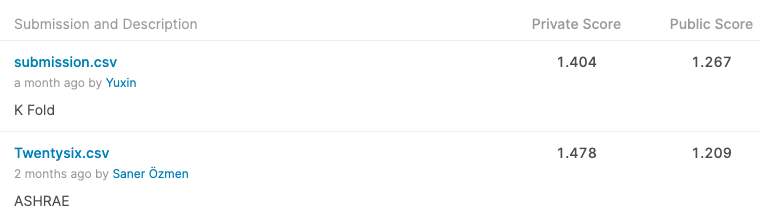](http://)

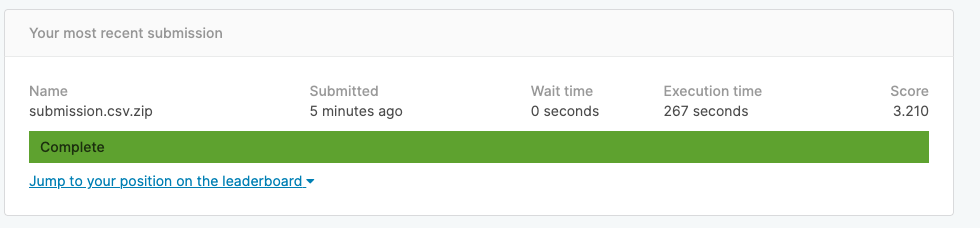

# Lessons learned and outlook
**IN GENERAL:**
1. We found ‘modin’ library can help accelerate pandas even on the laptop and so we tried to install it in windows. We learned that:
    * Pip install “modin[dask]” is ran in the command line, therefore, the code should be put in the command in terminal instead of interpreter.
    * If still get error when using modin to read data, it’s because Windows doesn’t support Ray which is the dependency of modin. To use it, we have to install WSL. But it would easier for laptops using Linux or Mac.
    * We didn’t use it in the end because we don’t want to install more applications.
2.	DataFrame.dtypes for data must be int, float or bool.
3.	Difference between statistics modeling (e.g. linear regression) and machine learning:
    * Statistical modeling is more about finding relationships between variables and the significance of those relationships. Test data is not necessary but we analyze confidential intervals, p value, test value to access the model’s accuracy.
    * Machine learning is more about prediction results, we don’t care much if the model is interpretable. Test data is normally needed to validate results’ accuracy.
4.	Even though in machine learning, we don’t care much about the independency/collinearity problems, but we still should ensure that the training data is as clean as possible, therefore, we should still drop the useless columns, which also reduce the data size and increase the speed.
5. The cells took to much time to execute, this was very annoying. It felt like a waste of time.
6. It was initially difficult to understand the different data sets and the connections between them. It took us some time to get the hang of it.
7. We encountered many unknown methods, so we had to research what each method does in order to use it properly.

**FOR THE MISSING VALUES:**

After tried several different solutions without efficiency, we saw a tutorial indicating a really simple but useful action before start looking for proper ML. This tutorial mentioned that it's better **to calculate a ''common-sense'' baseline**. This baseline is defined in how a person who has knowledge in that field would solve the problem without using any data science tricks. Alternatively, it can be a dummy or simple algorithm, consisting of few lines of code, to use as a baseline metric.
Baseline metrics can be different in regression and classification problems. For a regression problem, it can be a central tendency measure as the result for all predictions, such as the mean or the median. Since this is a regression problem and competition's results will be evaluated for root mean squared logarithmic error. Baseline metrics are important in a way that, if a ML model cannot beat the simple and intuitive prediction of a person's or an algorithm's guess, the original problem needs reconsideration or training data needs reframing.
e.g.The baseline guess is a score of 4.38
Baseline Performance on the valid set: RMSE = 2.1070
However, when we try linear regression, RMSE of the linear regression model is: 1.9895562449483846 without too much difference. Then why we are going to use such ML for prediction? By doing so, it's really easy to do the benchmark even if we don't start with any complicated statistics.


# References

Ref1: **As per the discussion in the following thread, https://www.kaggle.com/c/ashrae-energy-prediction/discussion/117083, there is some discrepancy in the meter_readings for different ste_id's and buildings. It makes sense to delete them**

Ref2: https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08

Ref3: https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-2-fe-lightgbm

Ref4: https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type

Others:

https://www.kaggle.com/migglu/odyssey-towards-a-sustainable-built-environment#Modeling-and-prediction
Random forest: https://www.kaggle.com/holoong9291/ashrae-great-energy-predict
https://www.kaggle.com/aldrinl/eda-rf-ashrae-great-energy-predictor
Lightgbm https://www.kaggle.com/kaushal2896/ashrae-eda-fe-lightgbm-1-12
Lightgbm: https://www.kaggle.com/isaienkov/lightgbm-fe-1-19
Kfold lightgbm: https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08
Stratified lightgb,: https://www.kaggle.com/roydatascience/ashrae-energy-prediction-using-stratified-kfold
https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-3-predictions
https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-2-fe-lightgbm#-4.-Compare-Several-Machine-Learning-Models-

https://www.kaggle.com/jaseziv83/a-deep-dive-eda-into-all-variables
https://www.kaggle.com/ishaan45/pandas-profiling-missing-value-imputation
https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction#14.-Handling-missing-values
https://www.kaggle.com/kaushal2896/ashrae-eda-fe-lightgbm-1-12
https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling
https://www.kaggle.com/vikassingh1996/ashrae-great-energy-insightful-eda-fe-lgbm
https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-2-fe-lightgbm
https://www.kaggle.com/drcapa/ashrae-feature-engineering-merge-data


https://www.youtube.com/watch?v=ErDgauqnTHk - Gopal Prasad Malakar
https://www.youtube.com/watch?v=l3OmtvcaTmM&list=PL1UM2yYgxPh-2kKL53wCsBQP5MoCBvH1z&index=5 Ligdi Gonzalez
https://www.youtube.com/watch?v=F7xj8H_p288&list=PL1UM2yYgxPh-2kKL53wCsBQP5MoCBvH1z&index=6 - Ligdi Gonzalez
https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf

## Previous Code

for df in [train, test]:
    df['air_temperature'] = df['air_temperature'].astype('float16')
    df['cloud_coverage'] = df['cloud_coverage'].astype("float16")
    df['dew_temperature'] = df['dew_temperature'].astype('float16')
    df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
    df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
    df['wind_direction'] = df['wind_direction'].astype('float32')
    df['wind_speed'] = df['wind_speed'].astype('float16')
    df['square_feet'] = df['square_feet'].astype("float32")
    df['building_id'] = df['building_id'].astype("int16")
    
train.drop('timestamp',axis=1,inplace=True)
test.drop('timestamp',axis=1,inplace=True)

train['number_unique_meter_per_building']
train['mean_meter_reading_per_building']
train['median_meter_reading_per_building']
train['std_meter_reading_per_building']

train['mean_meter_reading_on_year_built']
train['median_meter_reading_on_year_built']
train['std_meter_reading_on_year_built']

train['mean_meter_reading_per_meter']
train['median_meter_reading_per_meter']
train['std_meter_reading_per_meter']

train['mean_meter_reading_per_primary_usage']
train['median_meter_reading_per_primary_usage']
train['std_meter_reading_per_primary_usage']

train['mean_meter_reading_per_site_id']
train['median_meter_reading_per_site_id']
train['std_meter_reading_per_site_id']

Then again but with the test dataset.

le = LabelEncoder()

train['meter']= le.fit_transform(train['meter']).astype("uint8")
test['meter']= le.fit_transform(test['meter']).astype("uint8")
train['primary_use']= le.fit_transform(train['primary_use']).astype("uint8")
test['primary_use']= le.fit_transform(test['primary_use']).astype("uint8")

Check the correlation between the variables and eliminate the one's that have high correlation.Threshold for removing correlated variables:
threshold = 0.9

Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

y = train['meter_reading']
train.drop('meter_reading',axis=1,inplace=True)

categorical_cols = ['building_id','Month','meter','Hour','primary_use','DayOfWeek','DayOfMonth']

%%time
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.25,random_state=42)
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

lgb_train = lgb.Dataset(x_train, y_train,categorical_feature=categorical_cols)
lgb_test = lgb.Dataset(x_test, y_test,categorical_feature=categorical_cols)
del x_train, x_test , y_train, y_test

params = {'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.15,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'random_state': 47
         }

reg = lgb.train(params, lgb_train, num_boost_round=3000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval = 100)

del lgb_train,lgb_test

ser = pd.DataFrame(reg.feature_importance(),train.columns,columns=['Importance']).sort_values(by='Importance')
ser['Importance'].plot(kind='bar',figsize=(10,6))

del train

%%time
predictions = []
step = 50000
for i in range(0, len(test), step):
    predictions.extend(np.expm1(reg.predict(test.iloc[i: min(i+step, len(test)), :], num_iteration=reg.best_iteration)))
    
%%time
Submission['meter_reading'] = predictions
Submission['meter_reading'].clip(lower=0,upper=None,inplace=True)
Submission.to_csv("Twentysix.csv",index=None)